In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

import torch
from torch_geometric.datasets import KarateClub
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.utils import train_test_split_edges
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GAE
#error in karateclub:It seems that there is an issue with accessing the train_pos_edge_index attribute in the Karateclub dataset. The Karateclub dataset does not have predefined train, validation, and test splits like some other datasets in PyTorch Geometric.

2.1.0+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 45.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.datasets import KarateClub
from torch_geometric.transforms import NormalizeFeatures
# Load Karate Club dataset
dataset = KarateClub()
data = dataset[0]
# Normalize features
transform = NormalizeFeatures()
data = transform(data)

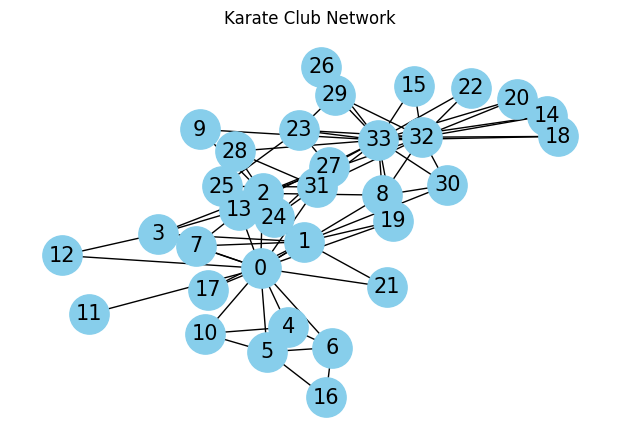

In [ ]:
# Extract graph structure
edge_index = data.edge_index
# Convert PyTorch tensor to numpy array
edge_index = edge_index.cpu().numpy()

# Create a graph
G = nx.Graph()
G.add_edges_from(edge_index.T)

# Visualize the graph
plt.figure(figsize=(6, 4))
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=800, edge_color='k', linewidths=1, font_size=15)
plt.title("Karate Club Network")
plt.show()

In [ ]:
# Perform train-test split
data = train_test_split_edges(data)

In [ ]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)


In [ ]:
# Parameters
out_channels = 16
num_features = dataset.num_features
epochs = 100

In [ ]:
# Model
model = GAE(GCNEncoder(num_features, out_channels))

# Move model and data to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = data.to(device)

In [ ]:
# Initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# Training function
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    return loss.item()

In [ ]:
# Test function
def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(data.x, data.train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

In [ ]:
# Training loop
for epoch in range(1, epochs + 1):
    loss = train()
    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    print('Epoch: {:03d}, Loss: {:.4f}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, loss, auc, ap))

Epoch: 001, Loss: 1.3756, AUC: 0.7347, AP: 0.7988
Epoch: 002, Loss: 1.3611, AUC: 0.7347, AP: 0.7988
Epoch: 003, Loss: 1.3443, AUC: 0.7551, AP: 0.8274
Epoch: 004, Loss: 1.3331, AUC: 0.7959, AP: 0.8239
Epoch: 005, Loss: 1.3077, AUC: 0.7959, AP: 0.8239
Epoch: 006, Loss: 1.3007, AUC: 0.7959, AP: 0.8239
Epoch: 007, Loss: 1.2761, AUC: 0.8776, AP: 0.8802
Epoch: 008, Loss: 1.2402, AUC: 0.8776, AP: 0.8598
Epoch: 009, Loss: 1.2074, AUC: 0.8571, AP: 0.8486
Epoch: 010, Loss: 1.1809, AUC: 0.7755, AP: 0.7882
Epoch: 011, Loss: 1.2013, AUC: 0.7551, AP: 0.7406
Epoch: 012, Loss: 1.1040, AUC: 0.7143, AP: 0.7191
Epoch: 013, Loss: 1.0987, AUC: 0.7347, AP: 0.7287
Epoch: 014, Loss: 1.0776, AUC: 0.6939, AP: 0.6977
Epoch: 015, Loss: 1.0322, AUC: 0.6939, AP: 0.6977
Epoch: 016, Loss: 0.9510, AUC: 0.6735, AP: 0.6850
Epoch: 017, Loss: 0.9726, AUC: 0.7347, AP: 0.7191
Epoch: 018, Loss: 1.0716, AUC: 0.7959, AP: 0.8072
Epoch: 019, Loss: 1.0243, AUC: 0.7959, AP: 0.8167
Epoch: 020, Loss: 0.9071, AUC: 0.7959, AP: 0.8167
